## K-Armed Bandits example
### Definitions
$q_*(a)=E[R_t|A_t=a]$: Value of an arbitrary action $a$ is the expected reward given that $a$ is selected <br/>
$a:$ Set of all possible actions <br/>
$Q_i(a):$ Action-value estimates at step i for any action <br/>
$A_i:$ Action taken at step i <br/>
$R_i:$ Reward obtained for action A_i <br/>

### Sample averages

We need to approximate $q_*(a)$, a simple way to do this is to average the rewards obtained so far for each action, this is called the sample-average method. $Q_t(a)$ converges to $q_*(a)$ for large numbers.  

$Q_t(a) = \frac{\text{sum of rewards when a taken prior to t}}{\text{sum of times a taken prior to t}} = \frac{\sum_{i=1}^{t-1}R_i \cdot \mathrm{I}_{A_i=a}}{\sum_{i=1}^{t-1}\mathrm{I}_{A_i=a}}$ 

Where $\mathrm{I} = 1$ if $A_i = a$ and $0$ if not, for all $a$. 

#### Incremental implementation 

The calculation of $Q_t(a)$ as written above is not computationally efficient since we need to recover all the values prior to $t$, a faster implementation would be to write $Q$ for a single action after it has been selected $n-1$ times as:

$Q_n = \frac{\sum_{i=1}^{n-1}R_i}{n-1}$

$R_i$ is the reward recieved after the $i$-th selection of the action. Then it is possible to write the incremental formula given $Q_n$ and $R_n$:

$Q_{n+1} = \frac{1}{n}\sum_{i=1}^{n}R_i =\frac{1}{n}\left(R_n + \frac{n-1}{n-1}\sum_{i=1}^{n-1}R_i\right) = \frac{1}{n}\left(R_n + (n-1)Q_n\right) = Q_n + \frac{1}{n}\left(R_n-Q_n\right)$

The equation above only needs the information regarding the previous reward and sample average of the last action taken.
### Greedy policy
Now that we have a way to estimate the values of every action, we need a policy to select which action to take at time step $t$ given the previous values. A greedy approach would be to choose the highest value.

$A_t = argmax_a Q_t(a)\rightarrow$Always exploits, no exploration.
#### $\epsilon$-Greedy
Choose action $A_t$ (greedily) with probability $1-\epsilon$, and choose randomly from all possible actions with probability $\epsilon$. This allows to exploit most of the time, while having room for exploration.

An advantage of this method is that $Q_{t\rightarrow \infty}(a) = q_*(a)$ for all $a$, because every action has the possibility ($\epsilon$) of being chosen, and the probability of choosing the optimal policy is $1-\epsilon$.

### Exercise 2.1 
If $\epsilon = 0.5$ there is a $1-0.5$ chance of choosing greedily, however, if the selection is random, the greedy option is still available.

$P(\text{greedy}) = P(\text{greedy}|\text{greed policy})P(\text{greed policy}) + P(\text{greedy}|\text{random policy})P(\text{random policy})$

$= 1\cdot (1-\epsilon) + \frac{1}{|a|}\cdot \epsilon = 0.5+\frac{0.5}{|a|}$

Where $|a|$ is the number of actions available.

### Exercise 2.2

In [1]:
import numpy as np
import time
import random
np.seterr(divide='ignore', invalid='ignore')

import tensorflow_probability as tfp
import tensorflow as tf
tf.enable_eager_execution()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

actions = np.array([1,2,3,4], dtype = np.float32) # possible actions ("a")
action_seq = np.array([1,2,2,2,3], np.float32) # Actions taken (A_i)
rewards = np.array([1,1,2,2,0], np.float32) #Rewards gained (R_i)
Q = np.zeros(actions.shape[0]) #Estimated values

def sample_avg(actions, action_seq, rewards):
    steps = range(1, len(action_seq)+1)
    q = np.zeros((len(steps)+1, len(actions)))
    for t in steps:
        num = np.array([rewards[:t][action_seq[0:t]==i] for i in actions])
        num = np.array([np.sum(num[i]) for i in range(len(num))])
        den = np.sum(np.array([action_seq[0:t]==i for i in actions]), axis = 1)
        q[t,:]=np.where(den == 0, den, num/den)
    return q
q = sample_avg(actions, action_seq, rewards)
print(q, action_seq)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[[0.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         1.         0.         0.        ]
 [1.         1.5        0.         0.        ]
 [1.         1.66666667 0.         0.        ]
 [1.         1.66666667 0.         0.        ]] [1. 2. 2. 2. 3.]


Step 1: Greedy (breaking ties randomly) or $\epsilon$, all actions have same Q.<br/>
Step 2: $\epsilon$, didn't choose highest Q action.<br/>
Step 3: Greedy (breaking ties randomly), options 1 and 2 have the same rewards.<br/>
Step 4: Greedy or $\epsilon$, option with highest Q is chosen, could be for greed or randomness.  
Step 5: $\epsilon$, didn't choose highest Q action.

## $\epsilon$-greedy method implementation

In [85]:
def squared_error(a, b):
    return (a-b)**2

def sample_avg(Q, step ,action, reward):
    n = step[action] + 1
    q = Q[action] + 1/n*(reward - Q[action]) 
    return q, n

def constant_step(Q, step, action, reward):
    alpha = .1
    q = Q[action] + alpha*(reward - Q[action])
    return q, alpha
    
class EpsilonGreedy():
    def __init__(self, n_actions = 10, epsilon = 0, q_initial = None, mean = 0, std = 1):
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.mean = mean
        self.std = std
        if q_initial is None:
            self.q_initial = np.random.normal(self.mean, self.std, self.n_actions)
        else:
            self.q_initial = q_initial
            
    def plot_true_values(self, samples):
        R = np.empty((samples, self.n_actions))
        for i in range(samples):
            R[i,:] = np.random.normal(loc = self.q_initial, scale = 1, size = self.n_actions)#q_real_dist.sample(samples).numpy().T.reshape(-1)
        
        R = R.T.reshape(-1)
        s = np.repeat([i for i in range(1, self.n_actions+1)], samples)
        df = pd.DataFrame(data = [s, R]).T
        df.columns = ['Action','Reward']
        plt.figure()
        sns.violinplot(x = 'Action', y = 'Reward', data = df)
             
    def choose_action(self, Q, N, t, policy): 
        if policy == 'epsilon':
            if 1 - self.epsilon > random.random(): #exploitation
                Q_argmax = [i for i, j in enumerate(Q) if j == max(Q)]
                if len(Q_argmax) == 1:
                    action = Q_argmax[0]
                else: #break ties randomly
                    action = random.choice(Q_argmax)

            else: #exploration
                action = np.random.randint(self.n_actions) 
            return action
        
        elif policy == 'UCB':
            c = 2
            a = np.where(N == 0 or t == 0, np.inf, Q + c*np.sqrt(np.log(t+1)/N))
            Q_argmax = [i for i, j in enumerate(a) if j == max(a)]
            if len(Q_argmax) == 1:
                action = Q_argmax[0]
            else: #break ties randomly
                action = random.choice(Q_argmax)
            return action
        
    def train(self, steps, iterations, policy = 'epsilon', stationary = True, update_method = sample_avg, init_Q = None):
        self.steps = steps           #how many steps make 1 run
        self.iterations = iterations #how many runs to make
        
        q_real = self.q_initial
        
        self.action_seq = np.empty((self.steps, self.iterations), dtype = np.int32)
        self.reward_err = np.empty_like(self.action_seq, dtype = np.float32)
        self.action_err = np.empty_like(self.action_seq, dtype = np.float32)
        
        start = time.time()
        iter_start = time.time()
        
        best_action = np.argmax(q_real)
        best_reward = q_real[best_action]
        for i in range(self.iterations):
            if init_Q is None:
                Q = [0]*self.n_actions #Estimated value
            else:
                Q = init_Q.copy()

            alpha = [0]*self.n_actions           #Number of ocurrences
            for t in range(self.steps):                    
                A = self.choose_action(Q, alpha, t, policy)
                R = np.random.normal(loc = q_real[A], scale = self.std)
                self.action_seq[t, i] = A
                self.action_err[t, i] = A == best_action
                self.reward_err[t, i] = R #squared_error(R, best_reward)
                Q[A], alpha[A] = update_method(Q, alpha, A, R)
                
                if not stationary: #change mean of real values                    
                    q_real = q_real + np.random.normal(loc = 0, scale = .01, size = 10)
                    if np.amax(q_real)>best_reward:
                        best_action = np.argmax(q_real)
                        best_reward = q_real[best_action]
                    
        print("Elapsed time: {:.2f} seconds".format(time.time() - start)) 
        return np.mean(self.reward_err, axis = 1), np.mean(self.action_err, axis = 1)

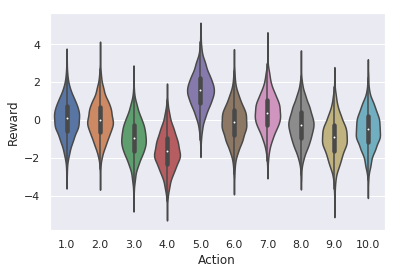

In [86]:
test_1 = EpsilonGreedy(epsilon = 0) 
test_2 = EpsilonGreedy(epsilon = .01, q_initial = test_1.q_initial) #real values are the same for all tests
test_3 = EpsilonGreedy(epsilon = .1, q_initial = test_1.q_initial)

test_1.plot_true_values(2000)


### Exercise 2.3
$\epsilon = .01$ will perform better in the long run, since eventually it will explore every action and select the best one $99\%$ of the time.

## Nonstationary problem

Recall that the update formula for sample averages is:

$Q_{n+1} = Q_n + \frac{1}{n}\left(R_n - Q_n\right)$

This comes from a general rule of the form: $NewEstimate \rightarrow OldEstimate + StepSize \cdot (Target - OldEstimate)$. In the case of nonsationary problems is better to set the step size as a constant in order to give more weight to recent rewards and less to older ones. Thus, the equation is written:

$Q_{n+1} = Q_n+\alpha\left(R_n - Q_n\right) = \alpha R_n +(1-\alpha)Q_n$

Notice that in general, $\alpha = \alpha_n(a)$. Using the formula for $Q_n$ recursively yields:

$Q_{n+1} = (1-\alpha)^nQ_1+\sum_{i=1}^n\alpha(1-\alpha)^{n-1}R_i$

Which is a weighted average between $Q_1$ and $R_i$. Choosing $\alpha_t(a) = \frac{1}{n(a)}$ results in the sample-average method and the method converges (for great $n$). The conditions of convergence are:
$\sum_{n=1}^{\infty}\alpha_n(a) = \infty, \hspace{1cm}\sum_{n=1}^{\infty}\alpha_n^2(a) < \infty$

The first condition ensures that steps are large enough to overcome initial conditions. The second guarantees that steps will eventually be small enough to converge. The choice $\alpha_n(a) = \frac{1}{n}$ meets those conditions whereas $\alpha_n(a) = \alpha \in (0,1]$ does not because the second condition is never met, that is it will not converge, rather it will vary depending on recent rewards. However, this is desirable in a nonstationary problem, since the true values change in time. Besides, step sizes that meet convergence conditions are often very slow and therfore seldom used in practical terms.

### Exercise 2.4
How would $Q_{n+1}$ be computed if $\alpha$ were not constant?

$Q_{n+1} = Q_n + \alpha_n(R_n-Q_n) = \alpha_nR_n +(1-\alpha_n)Q_n = \alpha_nR_n +(1-\alpha_n)(Q_{n-1} + \alpha_{n-1}(R_{n-1}-Q_{n-1}))$

$= \alpha_nR_n +(1-\alpha_n)(\alpha_{n-1}R_{n-1}+(1-\alpha_{n-1})Q_{n-1})=\ldots=Q_1\prod_{i=1}^n(1-\alpha_i)+ \sum_{i=1}^nR_i\alpha_i\prod_{j=i}^{n-1}(1-\alpha_{j+1})$

### Exercise 2.5
#### Epsilon greedy with $\epsilon = 0, 0.1, 0.01$ in stationary and nonstationary cases

Elapsed time: 13.99 seconds
Elapsed time: 5.89 seconds
Elapsed time: 5.55 seconds
Elapsed time: 13.12 seconds
Elapsed time: 13.08 seconds
Elapsed time: 12.63 seconds


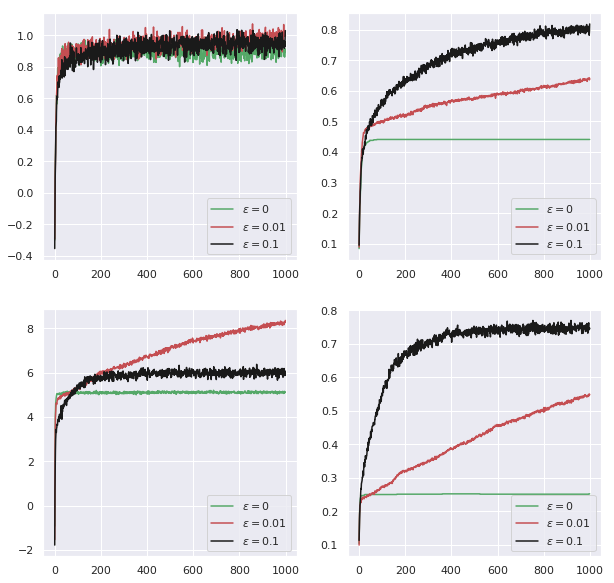

In [25]:
steps = 1000
iterations = 1000

stationary = True
rwd_1s, err_1s = test_1.train(steps = steps, iterations = iterations,stationary = stationary)
rwd_2s, err_2s = test_2.train(steps = steps, iterations = iterations, stationary = stationary)
rwd_3s, err_3s = test_3.train(steps = steps, iterations = iterations, stationary = stationary)

stationary = False
rwd_1ns, err_1ns = test_1.train(steps = steps, iterations = iterations, stationary = stationary)
rwd_2ns, err_2ns = test_2.train(steps = steps, iterations = iterations, stationary = stationary)
rwd_3ns, err_3ns = test_3.train(steps = steps, iterations = iterations, stationary = stationary)

fig, ax = plt.subplots(2,2, figsize = (10,10))

ax[0,0].plot(rwd_1s, 'g', label = r'$\epsilon = 0$')
ax[0,0].plot(rwd_2s, 'r', label = r'$\epsilon = 0.01$')
ax[0,0].plot(rwd_3s, 'k', label = r'$\epsilon = 0.1$')
ax[0,0].legend()

ax[0,1].plot(err_1s, 'g', label = r'$\epsilon = 0$')
ax[0,1].plot(err_2s, 'r', label = r'$\epsilon = 0.01$')
ax[0,1].plot(err_3s, 'k', label = r'$\epsilon = 0.1$')
ax[0,1].legend()

ax[1,0].plot(rwd_1ns, 'g', label = r'$\epsilon = 0$')
ax[1,0].plot(rwd_2ns, 'r', label = r'$\epsilon = 0.01$')
ax[1,0].plot(rwd_3ns, 'k', label = r'$\epsilon = 0.1$')
ax[1,0].legend()

ax[1,1].plot(err_1ns, 'g', label = r'$\epsilon = 0$')
ax[1,1].plot(err_2ns, 'r', label = r'$\epsilon = 0.01$')
ax[1,1].plot(err_3ns, 'k', label = r'$\epsilon = 0.1$')
ax[1,1].legend()

#### Epsilon greedy with $\epsilon = 0.1$ using sample average and constant ($\alpha = 0.1$) step size

Elapsed time: 5.53 seconds
Elapsed time: 5.49 seconds
Elapsed time: 12.78 seconds
Elapsed time: 12.40 seconds


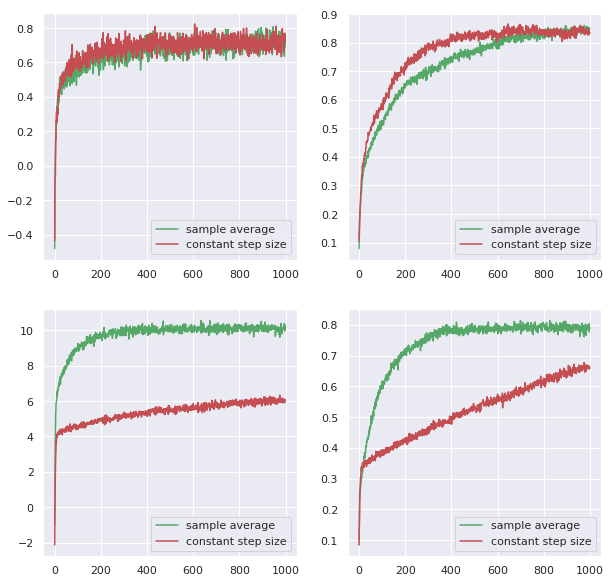

In [5]:
steps = 1000
iterations = 1000

stationary = True
rwd_1s, err_1s = test_3.train(steps = steps, iterations = iterations, stationary = stationary, 
                                     update_method = sample_avg)
rwd_2s, err_2s = test_3.train(steps = steps, iterations = iterations, stationary = stationary,
                                    update_method = constant_step)

stationary = False
rwd_1ns, err_1ns = test_3.train(steps = steps, iterations = iterations, stationary = stationary, 
                                     update_method = sample_avg)
rwd_2ns, err_2ns = test_3.train(steps = steps, iterations = iterations, stationary = stationary,
                                    update_method = constant_step)

fig, ax = plt.subplots(2,2, figsize = (10,10))

ax[0,0].plot(rwd_1s, 'g', label = 'sample average')
ax[0,0].plot(rwd_2s, 'r', label = 'constant step size')
ax[0,0].legend()

ax[0,1].plot(err_1s, 'g', label = 'sample average')
ax[0,1].plot(err_2s, 'r', label = 'constant step size')
ax[0,1].legend()

ax[1,0].plot(rwd_1ns, 'g', label = 'sample average')
ax[1,0].plot(rwd_2ns, 'r', label = 'constant step size')
ax[1,0].legend()

ax[1,1].plot(err_1ns, 'g', label = 'sample average')
ax[1,1].plot(err_2ns, 'r', label = 'constant step size')
ax[1,1].legend()

### Optimistic initial values

The methods mentioned (sample average and constant step) depend on $Q_1$ which means they are biased. In the sample average method the bias dissappears when each action has been taken once, since $Q_2 = Q_1+\frac{1}{1}(R_1-Q_1) = R_1$, however, in the constant step size method, the bias doesn't disappear, although it decreases exponentially as the number of times a given action is taken increases. The bias can be useful to provide prior information of the expected rewards.

Besides, initial values can be used to encourage exploration when using a greedy policy, by setting high initial values, the agent will go through each possibility beforegetting stuck in a greedy action. This is because in the begining the model will be dissapointed since the reward obtained is much less than the initial value, and therfore will try other options.

Optimistic initial values are not well suited for nonstationary problems because the exploration occurs only at the begining

Elapsed time: 16.49 seconds
Elapsed time: 16.36 seconds


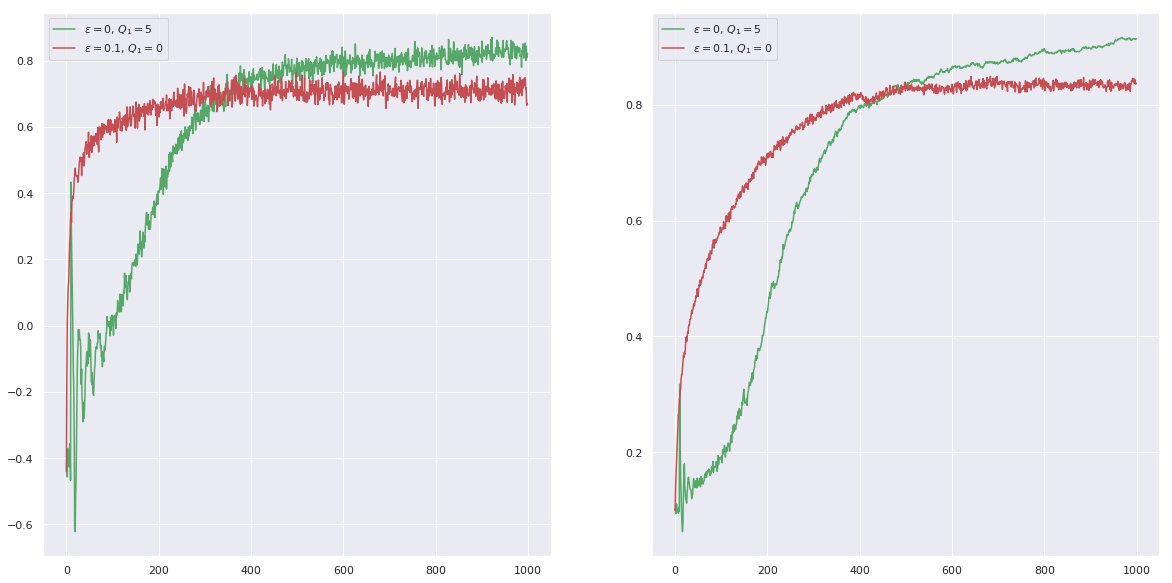

In [6]:
steps = 1000
iterations = 3000

stationary = True
rwd_1, err_1 = test_1.train(steps = steps, iterations = iterations, stationary = stationary, init_Q = [5]*10,
                           update_method = constant_step)
rwd_2, err_2 = test_3.train(steps = steps, iterations = iterations, stationary = stationary,
                           update_method = constant_step)

fig, ax = plt.subplots(1,2, figsize = (20,10))

ax[0].plot(rwd_1, 'g', label = r'$\epsilon = 0$, $Q_1 = 5$')
ax[0].plot(rwd_2, 'r', label = r'$\epsilon = 0.1$, $Q_1 = 0$')
ax[0].legend()

ax[1].plot(err_1, 'g', label = r'$\epsilon = 0$, $Q_1 = 5$')
ax[1].plot(err_2, 'r', label = r'$\epsilon = 0.1$, $Q_1 = 0$')
ax[1].legend()

#### Exercise 2.6

In the begining the model will explore every action, since every time it will be dissapointed and will end up choosing an action which still is in an optimistic value. When all actions are explored, it's more likely that the best option has the higher $Q$ value, resulting in the model choosing that action most of the time, which is shown in the graph as a spike around step 10 (the number of possible actions).

### Upper-Confidence-Bound action selection

Although the $\epsilon$-greedy method allows exploration, it doesn't measure the potential of each action to actually be optimal, there is no preference. It would be better if we could select explore but having information about the potential reward of each action, this is, taking into account how close are the estimates to being maximal and the uncertainty in those estimates. A policy that allows this is:

$A_t = argmax_a\left[Q_t(a)+c\sqrt{\frac{\ln{t}}{N_t(a)}}\right]$

$N_t(a)$ is the number of times action $a$ has been taken prior to step $t$, $c>0$ controls the degree of exploration. $N_t(a) = 0$ means $a$ is a maximizing action.

The square-root term acts as a measure of uncertainty of the estimate $Q_t(a)$. Therefoe, the quantity to maximize is an upper bound on the true reward for taking $a$. Notice that each selection of $a$ reduces the uncertainty, since $N_t(a)$ increases, besides, when an action other than $a$ is taken $t$ increases while $N$ remains the same, thus increasing the uncertainty.

Although UCB is better than $\epsilon$-greedy in the 10-armed testbed, it is not easily applicable to more complex problems of reinforcement learning, in particular nonstationary problems and large state-spaces

Elapsed time: 5.83 seconds
Elapsed time: 29.33 seconds


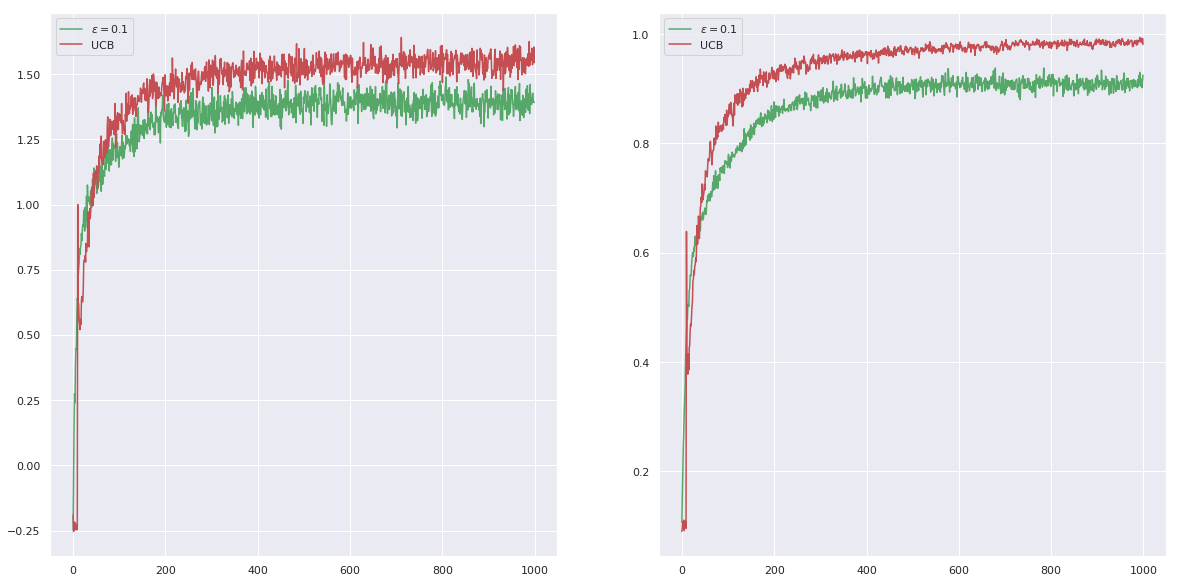

In [88]:
stationary = True
steps = 1000
iterations = 1000

rwd_1, err_1 = test_3.train(steps = steps, iterations = iterations, stationary = stationary)
rwd_2, err_2 = test_3.train(steps = steps, iterations = iterations, policy = 'UCB',stationary = stationary)

fig, ax = plt.subplots(1,2, figsize = (20,10))

ax[0].plot(rwd_1, 'g', label = r'$\epsilon = 0.1$')
ax[0].plot(rwd_2, 'r', label = 'UCB')
ax[0].legend()

ax[1].plot(err_1, 'g', label = r'$\epsilon = 0.1$')
ax[1].plot(err_2, 'r', label = 'UCB')
ax[1].legend()

### Gradient bandit algorithms

Instead of selecting actions based on action value estimates we can define a preference for each action $H_t(a)$ and select based on those preferences. Notice that the preferences are relative and are not rewards, that is a highr value only tells which action to take, not the actual rewards the model will receive. These preferences can be defined with a softmax distribution as follows.

$Pr\{A_t=a\} = \frac{e^{H_t(a)}}{\sum_{b=1}^ke^{H_t(a)}} = \pi_t(a)$

1.0